<a href="https://colab.research.google.com/github/dyaccu/Hackathon2025_Proyecto3_FlightOnTime/blob/main/Proyecto3_FlightOnTime_DataScience_Entregable.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ✈️ **PROYECTO 3: FlightOnTime - Predicción de Retrasos**
**Equipo de Data Science | Hackathon ONE 2025**

**Descripción**: Desarrollo de un modelo de Machine Learning (MVP) para predecir la probabilidad de retraso de un vuelo comercial, integrado mediante API REST.

# 🛠️ 1. Configuración del Entorno
Instalación de librerías y configuración de estilos gráficos.

In [1]:
# Instalamos librerías específicas para análisis
!pip install ppscore --quiet
!pip install --upgrade pandas --quiet

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import ppscore as pps
import joblib

# Módulos de Machine Learning
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Configuración de Estilo Visual
sns.set_theme(style="whitegrid", context="notebook")
plt.rcParams['figure.figsize'] = (10, 6)

print("✅ Entorno configurado correctamente.")

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 49.2 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires pandas==2.2.2, but you have pandas 1.5.3 which is incompatible.
geopandas 1.1.1 requires pandas>=2.0.0, but you have pandas 1.5.3 which is incompatible.
inequality 1.1.2 requires pandas>=2.1, but you have pandas 1.5.3 which is incompatible.
spopt 0.7.0 requires pandas>=2.1.0, but you have pandas 1.5.3 which is incompatible.
xarray 2025.12.0 requires pandas>=2.2, but you have pandas 1.5.3 which is incompatible.
mizani 0.13.5 requires pandas>=2.2.0, but you have pandas 1.5.3 which is incompatible.
momepy 0.10.0 requires pandas>=2.0, but y

# ☁️ 2. Ingreso de Datos (Desde GitHub)
Conexión directa al repositorio del equipo para asegurar la reproducibilidad.

In [2]:
# Enlace al archivo RAW en tu repositorio
url_dataset = 'https://raw.githubusercontent.com/dyaccu/Hackathon2025_Proyecto3_FlightOnTime/refs/heads/main/dataset_vuelos.csv'

print(f"🔄 Conectando con GitHub...")

try:
    df = pd.read_csv(url_dataset)
    print("✅ Conexión exitosa. Dataset cargado.")
    print(f"📊 Dimensiones: {df.shape[0]} vuelos x {df.shape[1]} variables.")
    display(df.head())
except Exception as e:
    print(f"❌ Error al cargar: {e}")

🔄 Conectando con GitHub...
✅ Conexión exitosa. Dataset cargado.
📊 Dimensiones: 10000 vuelos x 8 variables.


,aerolinea,origen,destino,distancia_km,fecha_partida,retraso,target_texto,fecha_iso
0,IB,AEP,EZE,909,2025-07-24 19:56:00,0,Puntual,2025-07-24T19:56:00
1,G3,BOG,LIM,2416,2025-10-16 21:08:00,0,Puntual,2025-10-16T21:08:00
2,AA,LIM,SCL,4567,2025-08-27 06:21:00,0,Puntual,2025-08-27T06:21:00
3,G3,MIA,MAD,3359,2025-09-04 09:16:00,0,Puntual,2025-09-04T09:16:00
4,G3,MAD,SCL,7572,2025-07-07 10:39:00,1,Retrasado,2025-07-07T10:39:00


# 🧠 3. Ingeniería de Características (Feature Engineering)
Transformación de datos crudos (fechas) en variables numéricas que el modelo pueda interpretar.

In [3]:
# 1. Conversión de fecha
df['fecha_partida'] = pd.to_datetime(df['fecha_partida'])

# 2. Creación de variables predictivas
# Extraemos patrones temporales: Mes (estacionalidad), Día (semana laboral) y Hora (pico de tráfico)
df['mes'] = df['fecha_partida'].dt.month
df['dia_semana'] = df['fecha_partida'].dt.dayofweek # 0=Lunes, 6=Domingo
df['hora'] = df['fecha_partida'].dt.hour

# 3. Selección de variables finales
# Eliminamos columnas que no se usarán en el entrenamiento
cols_drop = ['fecha_partida', 'fecha_iso', 'target_texto']
df_model = df.drop(columns=[c for c in cols_drop if c in df.columns])

print("✅ Features generadas: 'mes', 'dia_semana', 'hora'.")
display(df_model.head())

✅ Features generadas: 'mes', 'dia_semana', 'hora'.


,aerolinea,origen,destino,distancia_km,retraso,mes,dia_semana,hora
0,IB,AEP,EZE,909,0,7,3,19
1,G3,BOG,LIM,2416,0,10,3,21
2,AA,LIM,SCL,4567,0,8,2,6
3,G3,MIA,MAD,3359,0,9,3,9
4,G3,MAD,SCL,7572,1,7,0,10


# 🔍 4. Análisis Exploratorio de Datos (EDA)
Visualización de patrones y correlaciones en los datos.

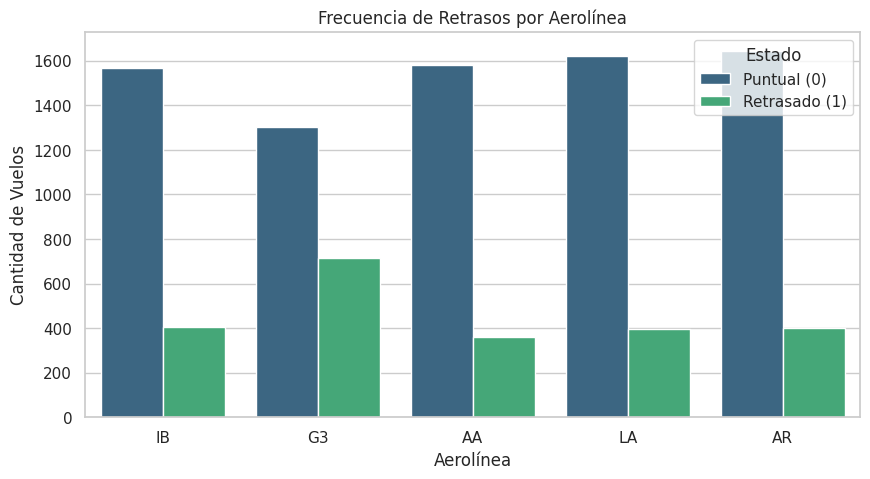

Calculando matriz de importancia (PPS)...


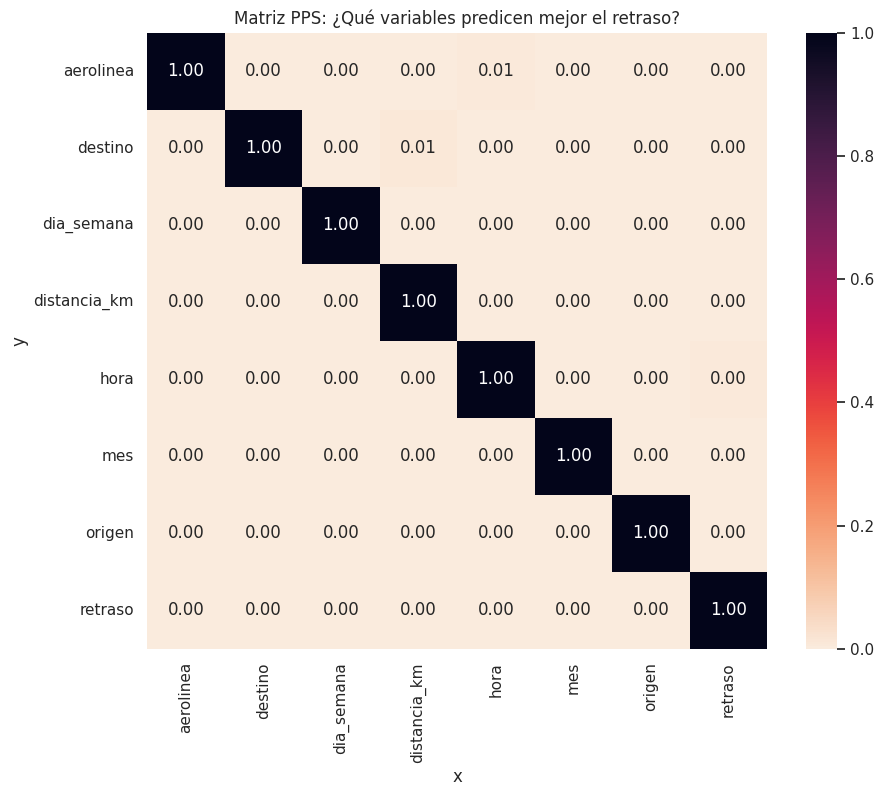

In [4]:
# Gráfico 1: Impacto de la Aerolínea en los Retrasos
plt.figure(figsize=(10, 5))
sns.countplot(data=df, x='aerolinea', hue='retraso', palette='viridis')
plt.title("Frecuencia de Retrasos por Aerolínea")
plt.xlabel("Aerolínea")
plt.ylabel("Cantidad de Vuelos")
plt.legend(title='Estado', labels=['Puntual (0)', 'Retrasado (1)'])
plt.show()

# Gráfico 2: Matriz de Poder Predictivo (PPS Score)
# Detecta relaciones no lineales entre variables
print("Calculando matriz de importancia (PPS)...")
matrix_pps = pps.matrix(df_model)[['x', 'y', 'ppscore']].pivot(columns='x', index='y', values='ppscore')

plt.figure(figsize=(10, 8))
sns.heatmap(matrix_pps, annot=True, cmap='rocket_r', fmt=".2f")
plt.title("Matriz PPS: ¿Qué variables predicen mejor el retraso?")
plt.show()

# 🤖 5. Entrenamiento del Modelo Predictivo
Entrenamiento de un algoritmo Random Forest para clasificación binaria.

In [5]:
# Variable Objetivo
target_col = 'retraso'

# 1. Codificación (One-Hot Encoding)
# Transformamos variables categóricas (texto) a numéricas
df_encoded = pd.get_dummies(df_model, columns=['aerolinea', 'origen', 'destino'], drop_first=True)

# 2. División de Datos (70% Train / 30% Test)
X = df_encoded.drop(target_col, axis=1)
y = df_encoded[target_col]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# 3. Entrenamiento
print(f"🚀 Entrenando modelo con {X_train.shape[0]} registros...")
modelo = RandomForestClassifier(n_estimators=100, max_depth=12, random_state=42)
modelo.fit(X_train, y_train)

print("✅ Modelo entrenado exitosamente.")

🚀 Entrenando modelo con 7000 registros...
✅ Modelo entrenado exitosamente.


# 📊 6. Evaluación de Desempeño
Validación de métricas clave (Accuracy, Precision, Recall).

🎯 ACCURACY (Exactitud): 77.43%

--- Reporte de Clasificación ---
              precision    recall  f1-score   support

           0       0.78      0.99      0.87      2316
           1       0.58      0.04      0.07       684

    accuracy                           0.77      3000
   macro avg       0.68      0.51      0.47      3000
weighted avg       0.73      0.77      0.69      3000



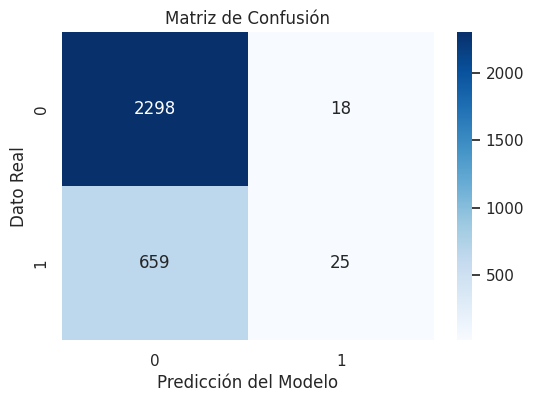

In [6]:
# Predicciones sobre el set de prueba
y_pred = modelo.predict(X_test)

# Métrica Global
acc = accuracy_score(y_test, y_pred)
print(f"🎯 ACCURACY (Exactitud): {acc:.2%}")

# Reporte Detallado
print("\n--- Reporte de Clasificación ---")
print(classification_report(y_test, y_pred))

# Matriz de Confusión
plt.figure(figsize=(6, 4))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
plt.title("Matriz de Confusión")
plt.xlabel("Predicción del Modelo")
plt.ylabel("Dato Real")
plt.show()

# 🔌 7. Simulación de API (Prueba de Integración JSON)
Simulación del output JSON requerido para validar el contrato con Back-End.

In [7]:
def simular_prediccion_api(indice_test):
    # Seleccionamos un vuelo de prueba
    input_data = X_test.iloc[[indice_test]]

    # El modelo calcula la PROBABILIDAD (requisito del cliente)
    probabilidad = modelo.predict_proba(input_data)[0][1] # Prob. de clase 1 (Retraso)

    # Determinamos el estado final
    estado = "Retrasado" if probabilidad > 0.5 else "Puntual"

    # Construimos la respuesta JSON
    respuesta = {
        "prevision": estado,
        "probabilidad": round(probabilidad, 2)
    }
    return respuesta

print("--- 📡 TEST DE RESPUESTA API (3 Ejemplos) ---")
for i in range(3):
    print(f"Vuelo #{i}: {simular_prediccion_api(i)}")

--- 📡 TEST DE RESPUESTA API (3 Ejemplos) ---
Vuelo #0: {'prevision': 'Puntual', 'probabilidad': np.float64(0.13)}
Vuelo #1: {'prevision': 'Puntual', 'probabilidad': np.float64(0.25)}
Vuelo #2: {'prevision': 'Puntual', 'probabilidad': np.float64(0.21)}


# 📦 8. Exportación para Despliegue
Generación de archivos .pkl para el equipo de desarrollo.

In [8]:
# Guardar Modelo
joblib.dump(modelo, 'flight_model.pkl')

# Guardar Estructura de Columnas (Vital para producción)
model_columns = list(X.columns)
joblib.dump(model_columns, 'model_columns.pkl')

print("📦 ARTEFACTOS GENERADOS:")
print("   1. flight_model.pkl")
print("   2. model_columns.pkl")
print("\n👉 Listos para ser integrados en la API Java.")

📦 ARTEFACTOS GENERADOS:
   1. flight_model.pkl
   2. model_columns.pkl

👉 Listos para ser integrados en la API Java.
